~~~
Copyright 2025 Google LLC

Licensed under the Apache License, Version 2.0 (the "License");
you may not use this file except in compliance with the License.
You may obtain a copy of the License at

    https://www.apache.org/licenses/LICENSE-2.0

Unless required by applicable law or agreed to in writing, software
distributed under the License is distributed on an "AS IS" BASIS,
WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
See the License for the specific language governing permissions and
limitations under the License.
~~~


## Setup

To complete this tutorial, you'll need to have a runtime with [sufficient resources](https://ai.google.dev/gemma/docs/core#sizes) to run the MedGemma model.

You can try out MedGemma 4B for free in Google Colab using a T4 GPU:

1. In the upper-right of the Colab window, select **▾ (Additional connection options)**.
2. Select **Change runtime type**.
3. Under **Hardware accelerator**, select **T4 GPU**.

**Note**: To run the demo with MedGemma 27B in Google Colab, you will need a runtime with an A100 GPU and use 4-bit quantization to reduce memory usage. The performance of quantized versions has not been evaluated.

### Get access to MedGemma

Before you get started, make sure that you have access to MedGemma models on Hugging Face:

1. If you don't already have a Hugging Face account, you can create one for free by clicking [here](https://huggingface.co/join).
2. Head over to the [MedGemma model page](https://huggingface.co/google/medgemma-4b-it) and accept the usage conditions.

### Authenticate with Hugging Face

Generate a Hugging Face `read` access token by going to [settings](https://huggingface.co/settings/tokens).

If you are using Google Colab, add your access token to the Colab Secrets manager to securely store it. If not, proceed to run the cell below to authenticate with Hugging Face.

1. Open your Google Colab notebook and click on the 🔑 Secrets tab in the left panel. <img src="https://storage.googleapis.com/generativeai-downloads/images/secrets.jpg" alt="The Secrets tab is found on the left panel." width=50%>
2. Create a new secret with the name `HF_TOKEN`.
3. Copy/paste your token key into the Value input box of `HF_TOKEN`.
4. Toggle the button on the left to allow notebook access to the secret.

In [1]:
import os
import sys

google_colab = "google.colab" in sys.modules and not os.environ.get("VERTEX_PRODUCT")

if google_colab:
    # Use secret if running in Google Colab
    from google.colab import userdata
    os.environ["HF_TOKEN"] = userdata.get("HF_TOKEN")
else:
    # Store Hugging Face data under `/content` if running in Colab Enterprise
    if os.environ.get("VERTEX_PRODUCT") == "COLAB_ENTERPRISE":
        os.environ["HF_HOME"] = "/content/hf"
    # Authenticate with Hugging Face
    from huggingface_hub import get_token
    if get_token() is None:
        from huggingface_hub import notebook_login
        notebook_login()

### Install dependencies

In [2]:
! pip install --upgrade --quiet accelerate bitsandbytes transformers

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 40.9/40.9 kB 2.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 72.9/72.9 MB 12.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.8/10.8 MB 86.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 44.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 21.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 39.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 6.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 14.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 8.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 6.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 

## Load model from Hugging Face Hub

In [3]:
from transformers import BitsAndBytesConfig
import torch

model_variant = "4b-it"  # @param ["4b-it", "27b-it", "27b-text-it"]
model_id = f"google/medgemma-{model_variant}"

use_quantization = True  # @param {type: "boolean"}

# @markdown Set `is_thinking` to `True` to turn on thinking mode. **Note:** Thinking is supported for the 27B variants only.
is_thinking = False  # @param {type: "boolean"}

# If running a 27B variant in Google Colab, check if the runtime satisfies
# memory requirements
if "27b" in model_variant and google_colab:
    if not ("A100" in torch.cuda.get_device_name(0) and use_quantization):
        raise ValueError(
            "Runtime has insufficient memory to run a 27B variant. "
            "Please select an A100 GPU and use 4-bit quantization."
        )

model_kwargs = dict(
    torch_dtype=torch.bfloat16,
    device_map="auto",
)

if use_quantization:
    model_kwargs["quantization_config"] = BitsAndBytesConfig(load_in_4bit=True)

The following sections contain standalone examples demonstrating how to use the model both directly and with the [`pipeline`](https://huggingface.co/docs/transformers/en/main_classes/pipelines) API. The `pipeline` API provides a simple way to use the model for inference while abstracting away complex details,  while directly using the model gives you complete control over the inference process, including preprocessing and postprocessing. In practice, you should select the method that is best suited for your use case.

Here, you will load the model directly and with the `pipeline` API for use in the next sections. Note that the multimodal variants and the 27B text-only variant are loaded with their respective tasks and classes.

**Load model with the `pipeline` API**

In [4]:
from transformers import pipeline

if "text" in model_variant:
    pipe = pipeline("text-generation", model=model_id, model_kwargs=model_kwargs)
else:
    pipe = pipeline("image-text-to-text", model=model_id, model_kwargs=model_kwargs)

pipe.model.generation_config.do_sample = False

config.json:   0%|          | 0.00/2.47k [00:00<?, ?B/s]

model.safetensors.index.json:   0%|          | 0.00/90.6k [00:00<?, ?B/s]

Fetching 2 files:   0%|          | 0/2 [00:00<?, ?it/s]

model-00001-of-00002.safetensors:   0%|          | 0.00/4.96G [00:00<?, ?B/s]

model-00002-of-00002.safetensors:   0%|          | 0.00/3.64G [00:00<?, ?B/s]

Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

generation_config.json:   0%|          | 0.00/156 [00:00<?, ?B/s]

processor_config.json:   0%|          | 0.00/70.0 [00:00<?, ?B/s]

chat_template.jinja:   0%|          | 0.00/1.53k [00:00<?, ?B/s]

preprocessor_config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

Using a slow image processor as `use_fast` is unset and a slow processor was saved with this model. `use_fast=True` will be the default behavior in v4.52, even if the model was saved with a slow processor. This will result in minor differences in outputs. You'll still be able to use a slow processor with `use_fast=False`.


tokenizer_config.json:   0%|          | 0.00/1.16M [00:00<?, ?B/s]

tokenizer.model:   0%|          | 0.00/4.69M [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/33.4M [00:00<?, ?B/s]

added_tokens.json:   0%|          | 0.00/35.0 [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/662 [00:00<?, ?B/s]

Device set to use cuda:0


## Run inference on images and text

This section demonstrates running inference on image-based tasks using multimodal variants.


In [6]:
if "text" in model_variant:
    raise ValueError(
        "You are using a text-only variant which does not support multimodal "
        "inputs. Please proceed to the 'Run inference on text only' section."
    )

**Specify image and text inputs**

In [7]:
import os
from PIL import Image
from IPython.display import Image as IPImage, display, Markdown

prompt = "Hi, can you find signs of cancer or future diseases in this patient of aspergillosis with aspergilloma in the middle lobe of right lung 7 year ago"  # @param {type: "string"}

# Image attribution: Stillwaterising, CC0, via Wikimedia Commons
image_url = "file://only hihi-img-00000-00000.jpg"  # @param {type: "string"}
! wget -nc -q {image_url}
image_filename = os.path.basename(image_url)
image = Image.open(image_filename)

**Format conversation**

In [8]:
role_instruction = "You are an expert radiologist."
if "27b" in model_variant and is_thinking:
    system_instruction = f"SYSTEM INSTRUCTION: think silently if needed. {role_instruction}"
    max_new_tokens = 1300
else:
    system_instruction = role_instruction
    max_new_tokens = 300

messages = [
    {
        "role": "system",
        "content": [{"type": "text", "text": system_instruction}]
    },
    {
        "role": "user",
        "content": [
            {"type": "text", "text": prompt},
            {"type": "image", "image": image}
        ]
    }
]

**Run model with the `pipeline` API**

---

**[ User ]**

Hi, can you find signs of cancer or future diseases in this patient of aspergillosis with aspergilloma in the middle lobe of right lung 7 year ago

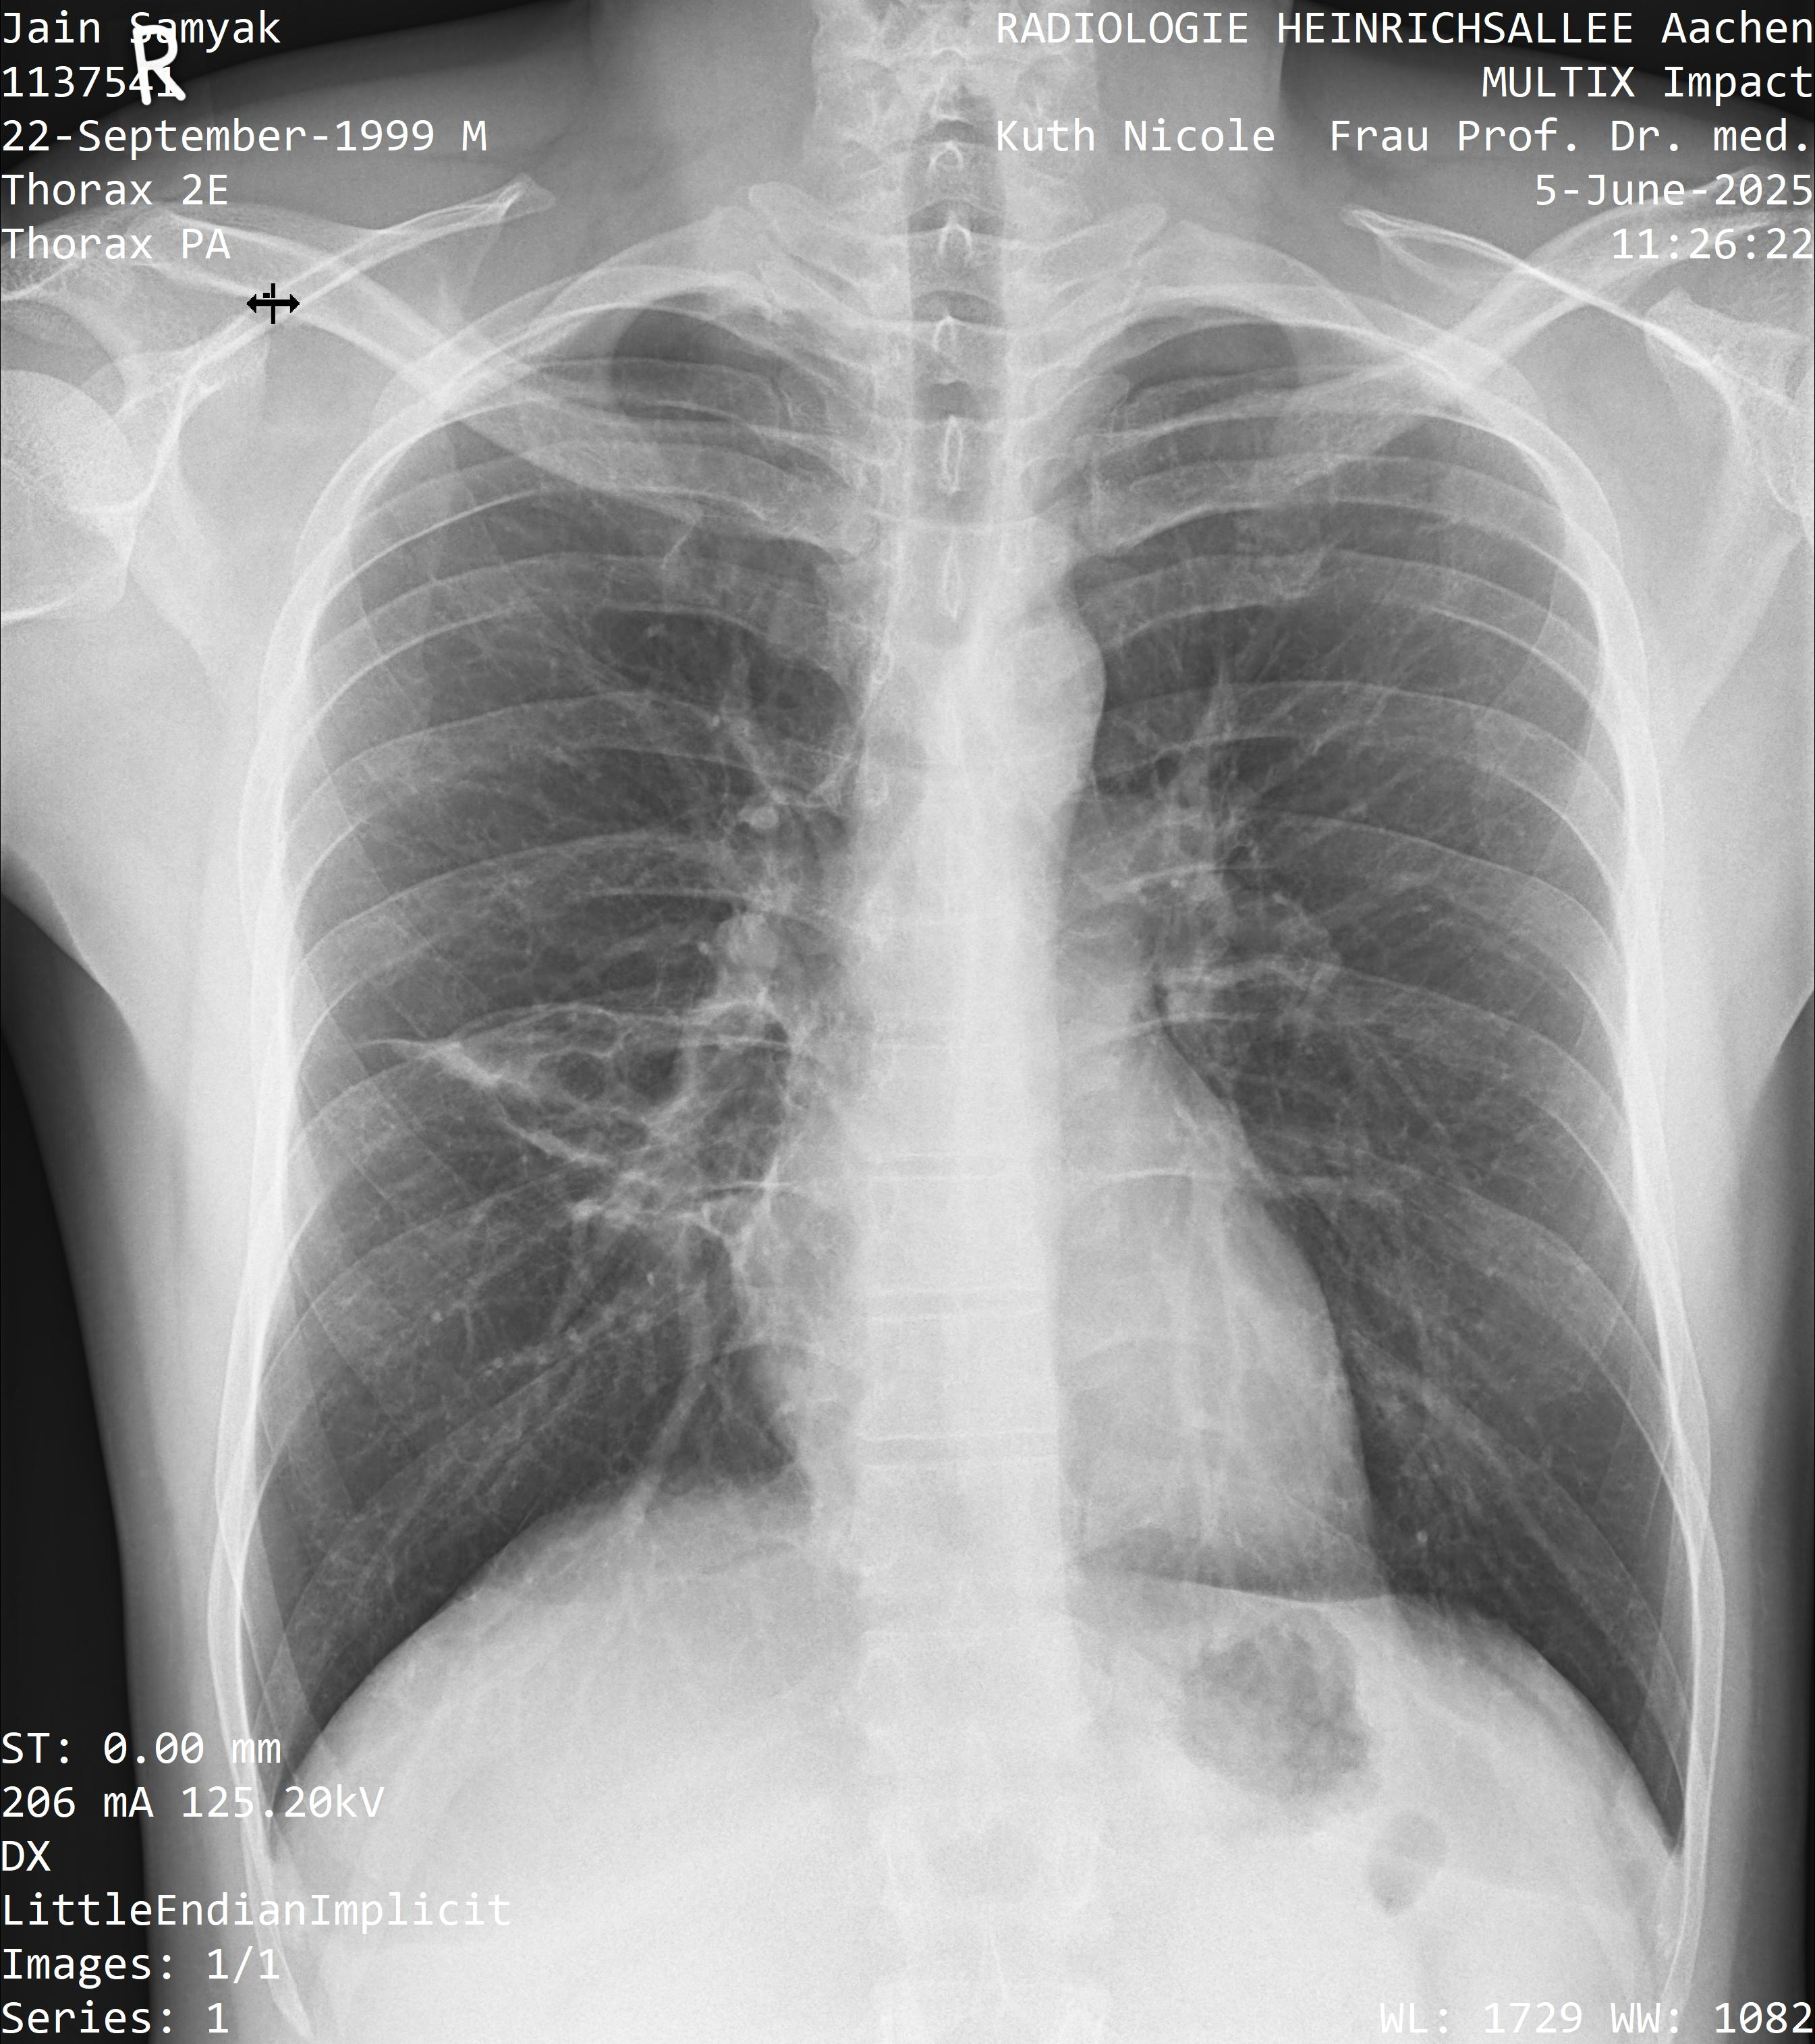

---

**[ MedGemma ]**

Based on the provided chest X-ray, here's an assessment:

**Findings:**

*   **Right Middle Lobe Aspergilloma:** There is a well-defined, round, dense opacity in the right middle lobe, consistent with an aspergilloma. This is a fungal ball, a mass of Aspergillus species that has colonized a pre-existing cavity.
*   **Right Upper Lobe Cavity:** There is a cavity in the right upper lobe.
*   **Normal Lung Fields:** The remaining lung fields appear relatively clear, with no obvious new infiltrates or masses.

**Interpretation:**

The presence of an aspergilloma in the right middle lobe, in a patient with a history of a right upper lobe cavity, is a common finding. Aspergillomas typically form in areas of lung destruction, such as cavities caused by tuberculosis, fungal infections, or other conditions.

**Important Considerations:**

*   **History:** The patient's history of aspergillosis is crucial.
*   **Follow-up:** Given the history of aspergillosis, it's important to consider the possibility of recurrence or progression of the disease.
*   **Further Imaging:** While the X-ray provides a good initial assessment, further imaging, such as a CT scan, may be helpful to evaluate the extent of the aspergilloma, any associated complications (e.g., bronchiectasis, hemoptysis), and

---

In [9]:
output = pipe(text=messages, max_new_tokens=max_new_tokens)
response = output[0]["generated_text"][-1]["content"]

display(Markdown(f"---\n\n**[ User ]**\n\n{prompt}"))
display(IPImage(filename=image_filename, height=300))
if "27b" in model_variant and is_thinking:
    thought, response = response.split("<unused95>")
    thought = thought.replace("<unused94>thought\n", "")
    display(Markdown(f"---\n\n**[ MedGemma thinking ]**\n\n{thought}"))
display(Markdown(f"---\n\n**[ MedGemma ]**\n\n{response}\n\n---"))